In [ ]:
def call_bedrock_guardrail(row, guardrail_id, guardrail_version):
    query = row["query"]
    context = row["context"]
    model_output = row["answer"]

    payload = {
        "source": "OUTPUT",
        "content": [
            {
                "text": {
                    "text": context,
                    "qualifiers": ["grounding_source"]
                }
            },
            {
                "text": {
                    "text": query,
                    "qualifiers": ["query"]
                }
            },
            {
                "text": {
                    "text": model_output
                }
            }
        ]
    }

    try:
        response = client.apply_guardrail(
            guardrailIdentifier=guardrail_id,
            guardrailVersion=guardrail_version,
            source=payload["source"],
            content=payload["content"]
        )
        # Extract grounding info
        action = response.get("action", "UNKNOWN")
        outputs = response.get("outputs", [{}])
        blocked_output = outputs[0].get("text") if outputs else None

        grounding_score = None
        threshold = None
        reason = None
        for a in response.get("assessments", []):
            if "groundingPolicy" in a:
                gp = a["groundingPolicy"]
                grounding_score = gp.get("score")
                threshold = gp.get("threshold")
                reason = gp.get("action")

        return pd.Series({
            "bedrock_action": action,
            "grounding_score": grounding_score,
            "grounding_threshold": threshold,
            "grounding_decision_reason": reason,
            "blocked_output_text": blocked_output
        })

    except Exception as e:
        return pd.Series({
            "bedrock_action": "ERROR",
            "grounding_score": None,
            "grounding_threshold": None,
            "grounding_decision_reason": str(e),
            "blocked_output_text": None
        })

def run_guardrail_vectorized(data, guardrail_id, guardrail_version):
    return pd.concat(
        [data,
         data.apply(call_bedrock_guardrail, axis=1, args=(guardrail_id, guardrail_version))],
        axis=1
    )


In [2]:
data= pd.read_csv("halueval_50x2_groundedness.csv")


if __name__ == "__main__":
    guardrail_id = "egi3t9xv4xej"
    guardrail_version = "1"

    # Example: data = pd.read_csv("groundedness_test.csv")
    enriched_data = run_guardrail_vectorized(data, guardrail_id, guardrail_version)

    print(enriched_data.head())
    enriched_data.to_csv("groundedness_guardrail_results.csv", index=False)


                                               query  \
0  The manager in which Mark Lazarus clashed with...   
1  The manager in which Mark Lazarus clashed with...   
2  No. 11 Squadron RAAF was based at what base, 2...   
3  No. 11 Squadron RAAF was based at what base, 2...   
4  Which movie starring Kim Roi-ha is based on Ko...   

                                             context  \
0   He transferred to Wolverhampton Wanderers for...   
1   He transferred to Wolverhampton Wanderers for...   
2  No. 11 Squadron is a Royal Australian Air Forc...   
3  No. 11 Squadron is a Royal Australian Air Forc...   
4  Kim Roi-ha (born November 15, 1965) is a South...   

                                              answer  label  \
0                                      1948 and 1964      1   
1  Mark Lazarus clashed with the manager of Wolve...      0   
2                                RAAF Base Edinburgh      1   
3         RAAF Base Edinburgh, located in Australia.      0   
4          

✅ Accuracy: 81.00%

📊 Classification Report:

                precision    recall  f1-score   support

Ungrounded (0)       0.97      0.64      0.77        50
  Grounded (1)       0.73      0.98      0.84        50

      accuracy                           0.81       100
     macro avg       0.85      0.81      0.80       100
  weighted avg       0.85      0.81      0.80       100

🧮 Confusion Matrix:

                Ungrounded (0)  Grounded (1)
Ungrounded (0)              32            18
Grounded (1)                 1            49


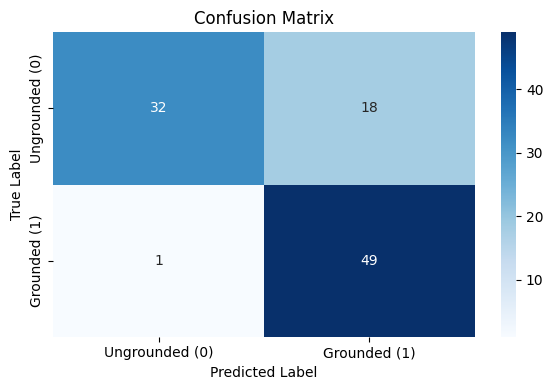

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Load CSV
results = pd.read_csv("groundedness_guardrail_results.csv")
df = pd.DataFrame(results)

# Step 2: Convert Bedrock action to predicted label
# GUARDRAIL_INTERVENED => ungrounded => 0
# NONE => grounded => 1
df["predicted"] = df["bedrock_action"].map({
    "GUARDRAIL_INTERVENED": 0,
    "NONE": 1
})

# Step 3: Accuracy & Report
accuracy = accuracy_score(df["label"], df["predicted"])
report = classification_report(df["label"], df["predicted"], target_names=["Ungrounded (0)", "Grounded (1)"])

print(f"✅ Accuracy: {accuracy:.2%}\n")
print("📊 Classification Report:\n")
print(report)

# Step 4: Confusion Matrix
cm = confusion_matrix(df["label"], df["predicted"])
labels = ["Ungrounded (0)", "Grounded (1)"]

print("🧮 Confusion Matrix:\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# Step 5: Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()